In [58]:
import numpy as np
import pandas as pd
import scipy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.mixture import GaussianMixture
import umap
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer import (ConfirmatoryFactorAnalyzer,ModelSpecificationParser)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Getting to know the data
churn_df = pd.read_csv('telcochurn.csv')
churn_df.columns = map(str.lower, churn_df.columns)
print(churn_df.head())
churn_df1 = churn_df.copy()

   customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      multiplelines internetservice onlinesecurity  ... deviceprotection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  techsupport streamingtv streamingmovies        contract pape

In [6]:
le = LabelEncoder()
y = le.fit_transform(churn_df['churn'])

In [8]:
churn_df['y'] = y
churn_df.drop(['churn', 'customerid'], inplace = True, axis =1)
categorical_df = churn_df.select_dtypes(include = 'object')
numeric_df = churn_df.select_dtypes(include =['int', 'float'])

In [11]:
numeric_df.drop('seniorcitizen', axis = 1, inplace = True)
categorical_df['seniorcitizen'] = churn_df['seniorcitizen']

In [13]:
# replacing spaces with nan in totalcharges variable
churn_df['totalcharges'] = churn_df['totalcharges'].apply(str.strip).replace(" ", np.nan)

In [18]:
# converting total charges to float 
churn_df['totalcharges'] = pd.to_numeric(churn_df['totalcharges'], downcast = 'float')

In [22]:
#replacing missing values in totalcharges with mean
churn_df.loc[:, 'totalcharges'].fillna(churn_df['totalcharges'].mean(), inplace = True)

In [26]:
categorical_df.drop('totalcharges', axis =1, inplace = True)

In [27]:
numeric_df['totalcharges'] = churn_df['totalcharges']

In [29]:
numeric_df.drop('y', axis =1, inplace = True)

In [48]:
churn_df.drop('y', axis =1, inplace = True)

In [31]:
corr = numeric_df.corr()
print(corr)

                  tenure  monthlycharges  totalcharges
tenure          1.000000        0.247900      0.824757
monthlycharges  0.247900        1.000000      0.650468
totalcharges    0.824757        0.650468      1.000000


#### Totalcharges has good correlation with monthlycharges and tenure

In [32]:
col_list = list(categorical_df.columns)

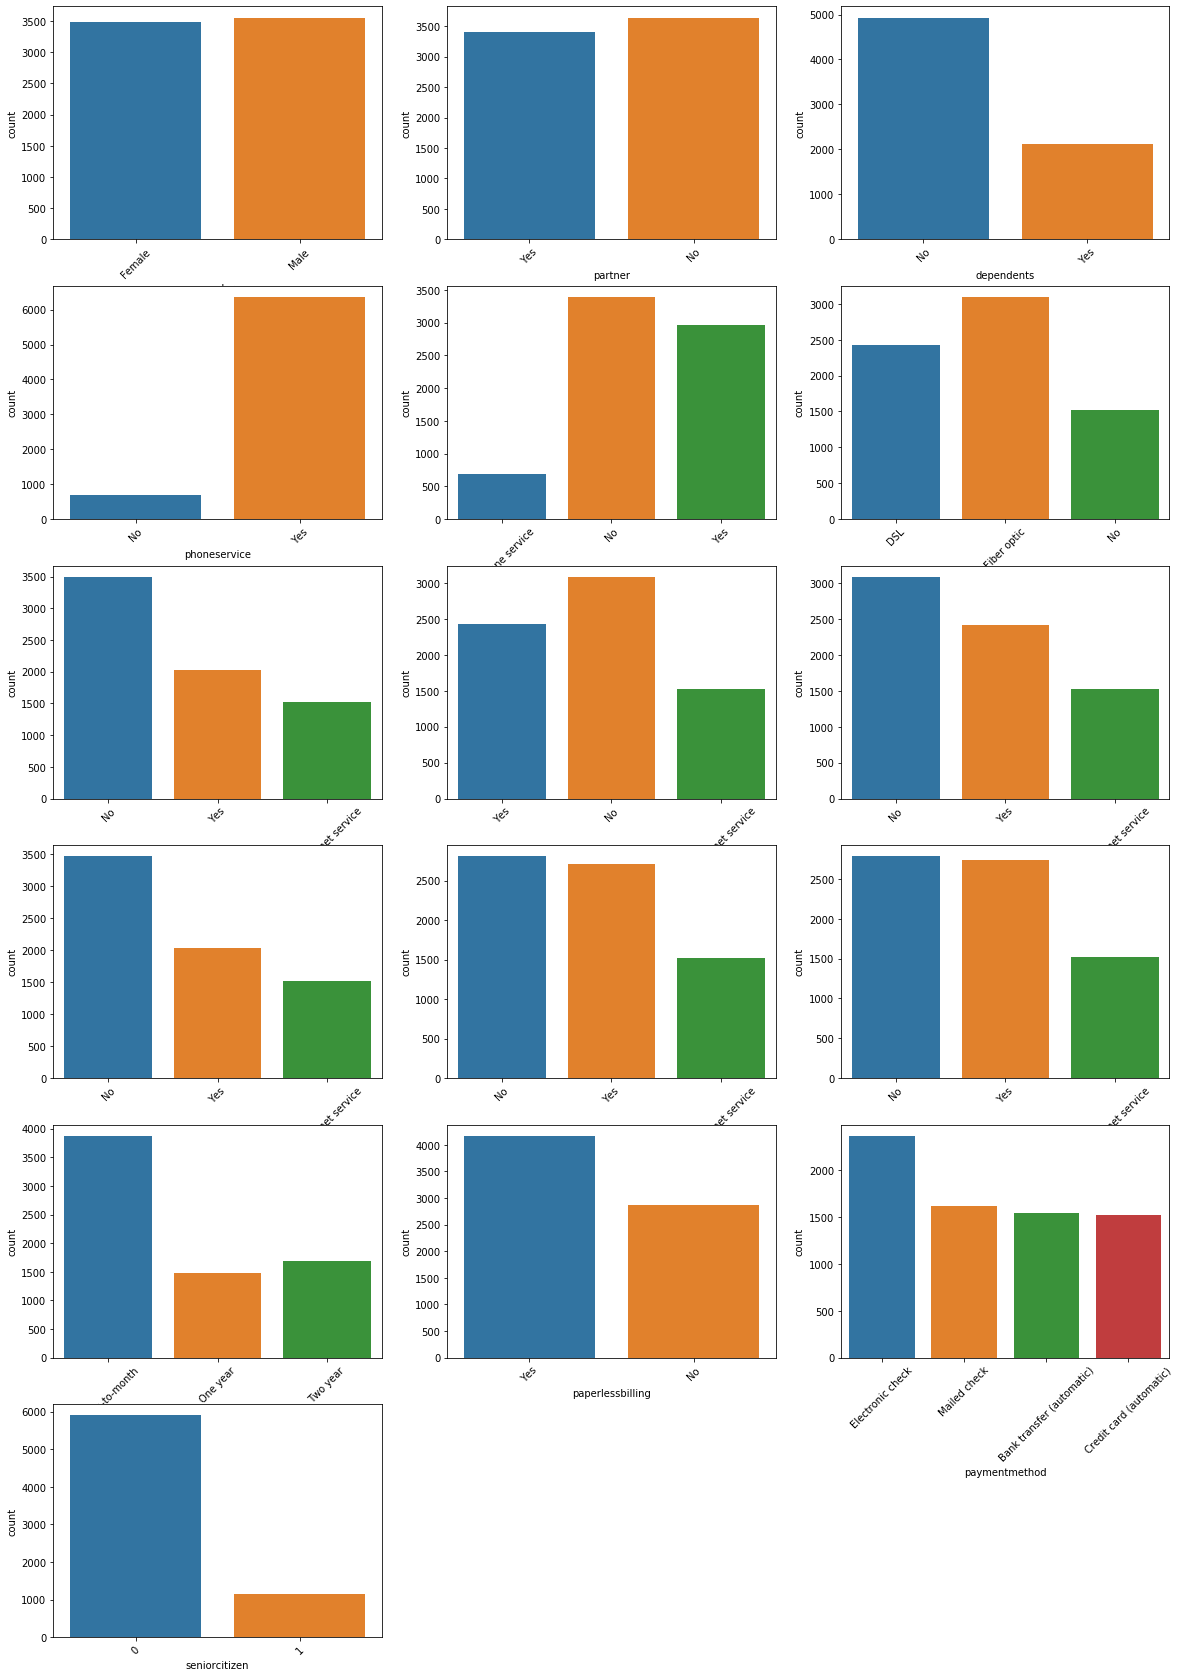

In [36]:
plt.figure(figsize = (20,30))
for index, col in enumerate(col_list):
    plt.subplot(6,3, index+1)
    sns.countplot(categorical_df[col])
    plt.xticks(rotation = 45)

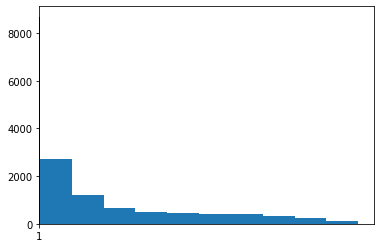

In [38]:
# Visually checking for normality of numeric variables
plt.hist(numeric_df['totalcharges'])
plt.show()

DescribeResult(nobs=7043, minmax=(18.8, 8684.8), mean=2283.3005, variance=5130226.0, skewness=0.9621889591217041, kurtosis=-0.2281579236053748)


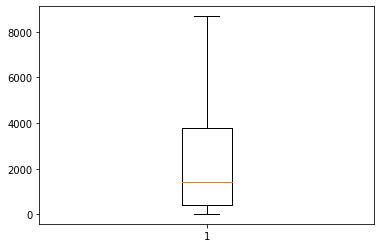

In [40]:
plt.boxplot(numeric_df['totalcharges'])
print(stats.describe(numeric_df['totalcharges']))

DescribeResult(nobs=7043, minmax=(18.25, 118.75), mean=64.76169246059918, variance=905.4109343405098, skewness=-0.2204774644391769, kurtosis=-1.2572191009381857)

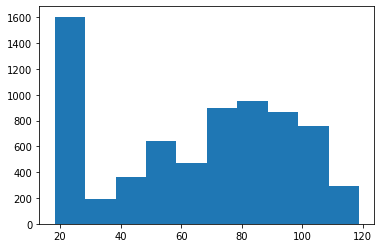

In [41]:
plt.hist(numeric_df['monthlycharges'])
stats.describe(numeric_df['monthlycharges'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1edd7438>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1edd7630>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1edd7470>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1edce710>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1edcec88>],
 'means': []}

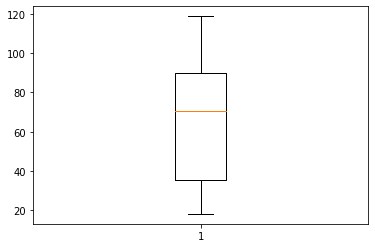

In [42]:
plt.boxplot(numeric_df['monthlycharges'])

DescribeResult(nobs=7043, minmax=(0, 72), mean=32.37114865824223, variance=603.1681081237368, skewness=0.2394887299846216, kurtosis=-1.3872386910324277)

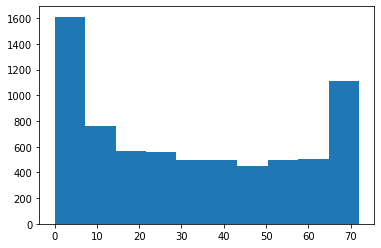

In [43]:
plt.hist(numeric_df['tenure'])
stats.describe(numeric_df['tenure'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1ede4cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f75e0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1ede4898>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f75e160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a22b51dd8>],
 'means': []}

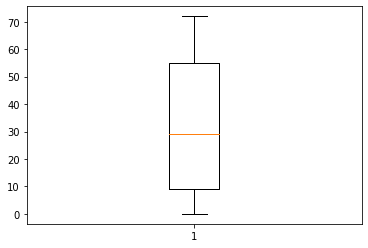

In [44]:
plt.boxplot(numeric_df['tenure'])

In [45]:
# Scaling the numeric variables
scaler = StandardScaler()
scaler_df = scaler.fit_transform(numeric_df)

In [50]:
preprocess = make_column_transformer(
    (OneHotEncoder(), ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
     'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
     'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
     'paymentmethod']), (StandardScaler(), ['tenure', 'monthlycharges', 'totalcharges']),
    remainder = 'passthrough'
)

In [51]:
X = preprocess.fit_transform(churn_df)

In [57]:
X.shape

(7043, 45)

In [54]:
# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
X_pca = pca.fit_transform(X)

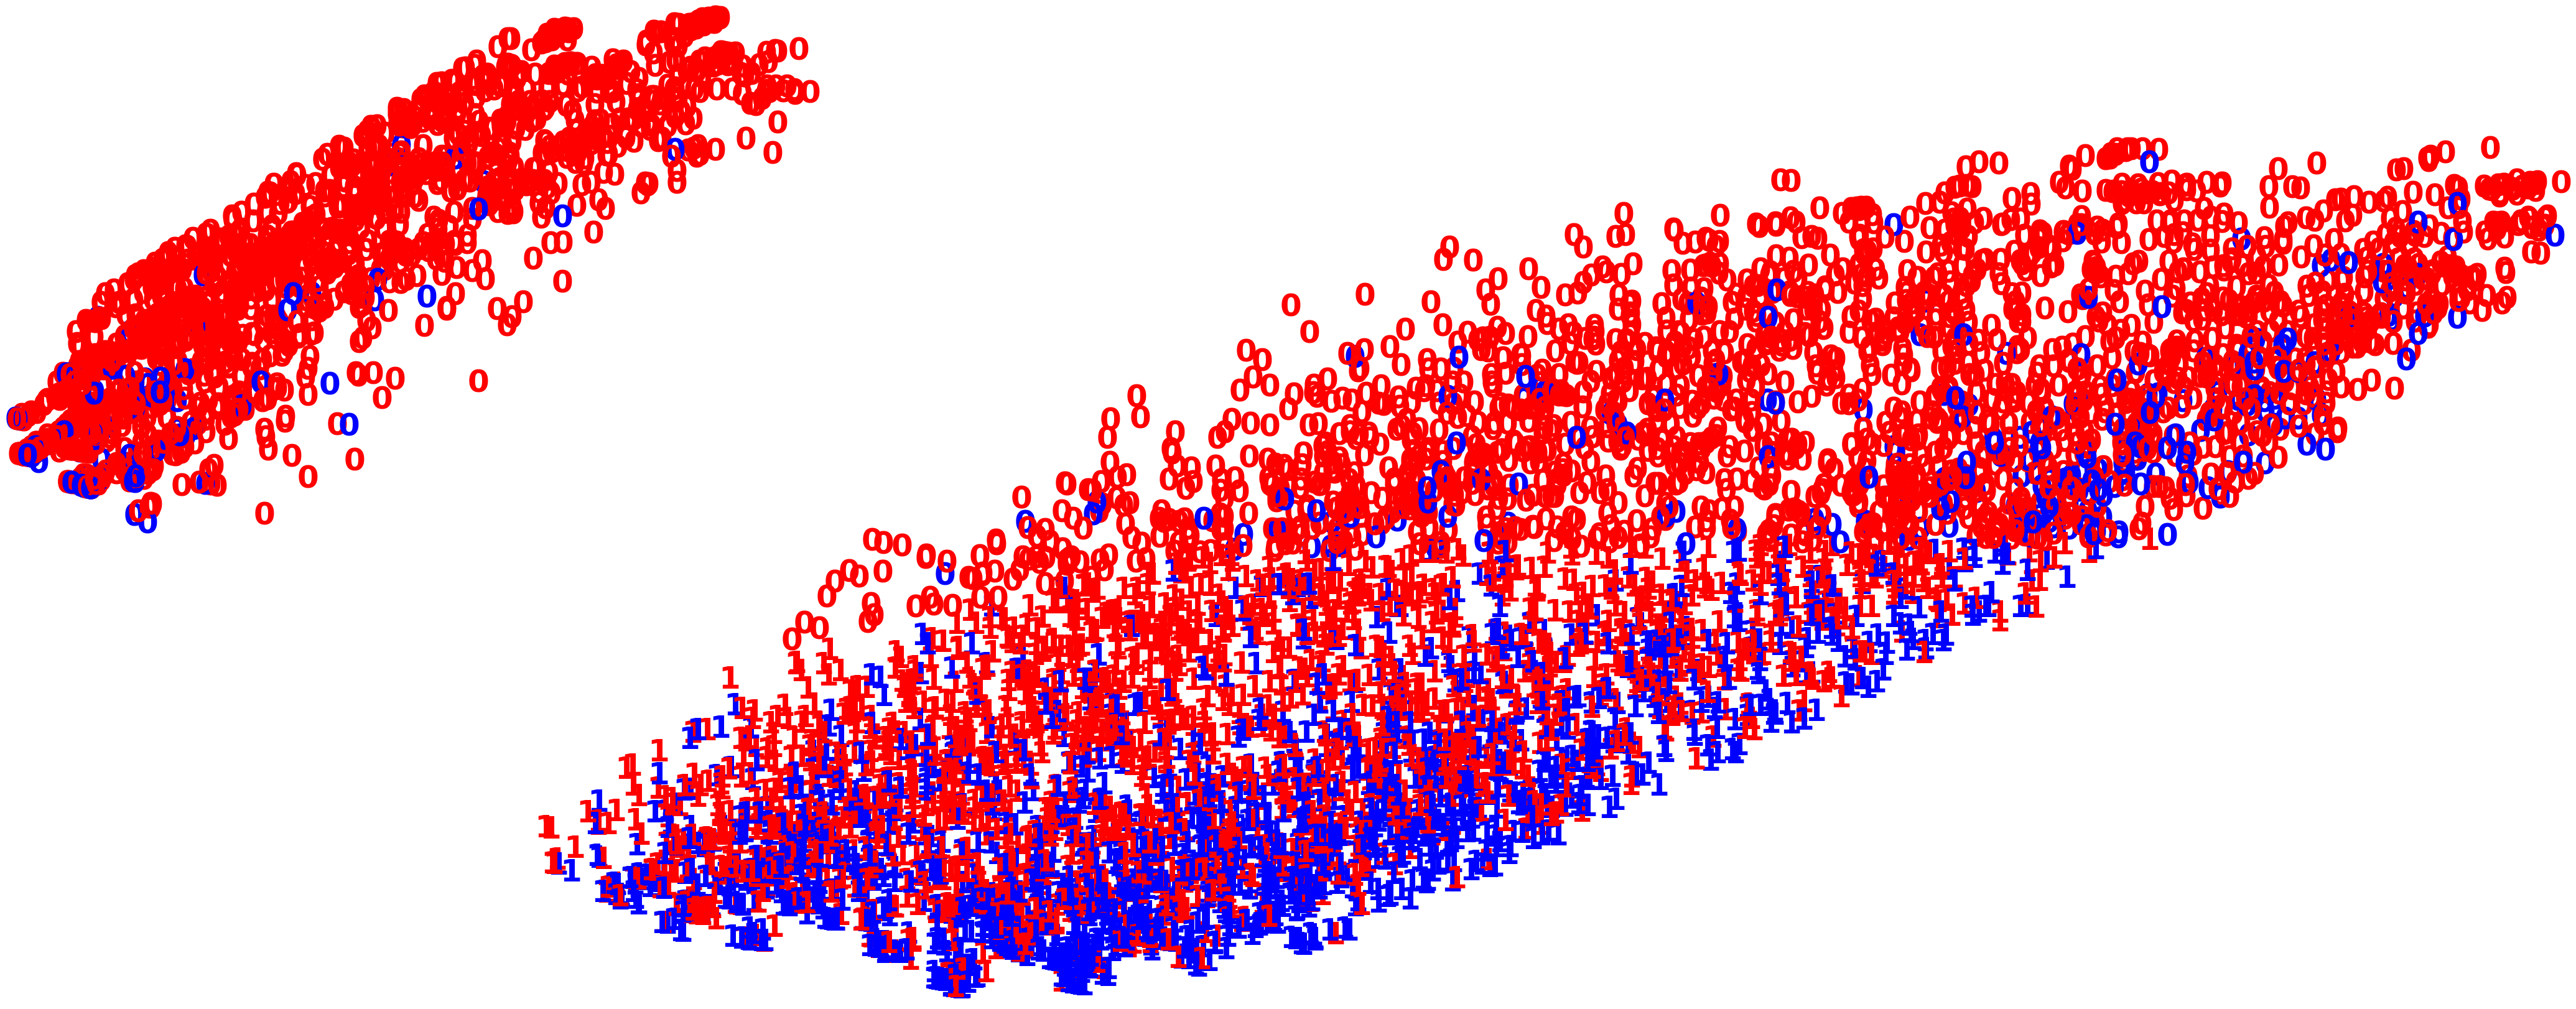

In [55]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_pca)
pca = PCA(n_components=2).fit_transform(X_pca)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [56]:
print("Adjusted Rand Index of the Hierarchical solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the Hierarchical solution: {}"
      .format(metrics.silhouette_score(X_pca, clusters, metric='euclidean')))

Adjusted Rand Index of the Hierarchical solution: 0.13268612042567843
The silhouette score of the Hierarchical solution: 0.3602927712722579


In [75]:
# Defining the DBSCAN clustering
dbscan_clusterm = DBSCAN(eps=1, min_samples=1)

# Fit model
clustersm = dbscan_clusterm.fit_predict(X_pca)
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersm)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_pca, clustersm, metric='euclidean')))

Adjusted Rand Index of the DBSCAN solution: -0.06539325963610504
The silhouette score of the DBSCAN solution: 0.5281972100194051


### The DBSCAN has improved the Silhouette score, however, the ARI still in negative which means clusters of datapoints  are closer to other datapoints in the cluster than they are to datapoints in the other clusters, which is good, however, I realised that performing PCA on Categorical Variables may not give meaninful results and most of the clustering algorithms are based on distance except hierarchical clustering with affinity cosine. 

### After a lot of research, I came to know that we can use MCA which is similar to PCA for categorical variables. Performing MCA on Categorical Variables and PCA on numeric variables and perform clustering algorithms on combine PCA and MCA data

In [76]:
import prince
mca = prince.MCA(n_components=2, n_iter=3, copy=True,
                 check_input=True, engine='auto', random_state=42)

In [79]:
cat_mca

,0,1
0,-0.568231,-0.194027
1,-0.185669,-0.101442
2,-0.290596,-0.341476
3,-0.404144,0.440307
4,-0.417000,-0.809263
...,...,...
7038,-0.272075,0.737148
7039,-0.352816,0.538922
7040,-0.525976,-0.035346
7041,-0.383457,-0.536646


In [92]:
# Defining the DBSCAN clustering
dbscan_clusterm1 = DBSCAN(eps=1, min_samples=1)

# Fit model
clustersm1 = dbscan_clusterm1.fit_predict(cat_mca)
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersm1)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(cat_mca, clustersm1, metric='euclidean')))

Adjusted Rand Index of the DBSCAN solution: -0.06539325963610504
The silhouette score of the DBSCAN solution: 0.7178941245343581


In [82]:
## After performing MCA on categorical variables and using just categorical variables increased the silhouette 
## score to 0.70, now we can merge PCA transformed numeric variables to new data and see how it works

In [86]:
pca_numeric = PCA(n_components = 2).fit_transform(scaler_df)

In [88]:
##Converting pca_numeric to Dataframe to merge with cat_mca
pca_numeric = pd.DataFrame(pca_numeric)

In [89]:
mca_pca = pd.merge(cat_mca, pca_numeric, left_index = True, right_index = True)

In [91]:
mca_pca.head()

,0_x,1_x,0_y,1_y
0,-0.568231,-0.194027,-1.950056,0.082900
1,-0.185669,-0.101442,-0.204166,0.235309
2,-0.290596,-0.341476,-1.516292,-0.522263
3,-0.404144,0.440307,-0.201051,0.891673
4,-0.417000,-0.809263,-1.231338,-0.964803


In [93]:
# Defining the DBSCAN clustering
dbscan_clusterm2 = DBSCAN(eps=1, min_samples=1)

# Fit model
clustersm2 = dbscan_clusterm2.fit_predict(mca_pca)
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersm2)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(mca_pca, clustersm2, metric='euclidean')))

Adjusted Rand Index of the DBSCAN solution: -0.06539325963610504
The silhouette score of the DBSCAN solution: 0.39357223038188793


In [94]:
from sklearn.mixture import GaussianMixture
gmm_cluster2 = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters2 = gmm_cluster2.fit_predict(mca_pca)
print("Adjusted Rand Index of the Gaussian solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters2)))
print("The silhouette score of the Gaussian solution: {}"
      .format(metrics.silhouette_score(mca_pca, clusters2, metric='euclidean')))

Adjusted Rand Index of the Gaussian solution: -0.06539325963610504
The silhouette score of the Gaussian solution: 0.39357223038188793


In [96]:
agg_clustermp = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clustersmp = agg_clustermp.fit_predict(mca_pca)
print("Adjusted Rand Index of the Hierarchical solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersmp)))
print("The silhouette score of the Hierarchical solution: {}"
      .format(metrics.silhouette_score(mca_pca, clustersmp, metric='cosine')))

Adjusted Rand Index of the Hierarchical solution: -0.022012851383502313
The silhouette score of the Hierarchical solution: 0.4220229162587857


### The silhouette score went down with merging cat_mca and numeric_pca variables. Finally using categorical variables (dummy coded ) with numeric_pca to see if it works

In [97]:
preprocess_ohe = make_column_transformer(
    (OneHotEncoder(), ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
     'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
     'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
     'paymentmethod']), remainder = 'passthrough'
)

In [99]:
cat_ohe = preprocess_ohe.fit_transform(categorical_df)

In [101]:
## Converting cat_ohe to Dataframe to merge with numeric pca data 
cat_ohe = pd.DataFrame(cat_ohe)

In [102]:
cat_ohe_pca = pd.merge(pca_numeric, cat_ohe, left_index = True, right_index = True)

In [104]:
cat_ohe_pca.head(3)

,0_x,1_x,0_y,1_y,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,40,41
0,-1.950056,0.082900,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.204166,0.235309,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.516292,-0.522263,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [105]:
## Performing heirarchical clustering with Affinity = cosine because that is the only algorithm that 
##does not use distance for clustering
agg_clusterf = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clustersf = agg_clusterf.fit_predict(cat_ohe_pca)
print("Adjusted Rand Index of the Hierarchical solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersf)))
print("The silhouette score of the Hierarchical solution: {}"
      .format(metrics.silhouette_score(cat_ohe_pca, clustersf, metric='cosine')))

Adjusted Rand Index of the Hierarchical solution: 0.011134284929494255
The silhouette score of the Hierarchical solution: 0.2577667231309324


### The highest silhouette score, I could achieve was 0.71 using MCA to reduce dimensionality and using DBSCAN approach, however the score went down after adding pca_numeric variables to that data and the score we achieved may not be meaningful

In [108]:
mca1 = mca.fit_transform(cat_ohe)

In [113]:
mca2 = pd.merge(mca1, pca_numeric, left_index = True, right_index = True)

In [114]:
agg_clusterfm = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clustersfm = agg_clusterfm.fit_predict(mca2)
print("Adjusted Rand Index of the Hierarchical solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersfm)))
print("The silhouette score of the Hierarchical solution: {}"
      .format(metrics.silhouette_score(mca2, clustersfm, metric='cosine')))

Adjusted Rand Index of the Hierarchical solution: -0.010670715973026284
The silhouette score of the Hierarchical solution: 0.46733049608086663


In [116]:
# Defining the DBSCAN clustering
dbscan_clusterf1 = DBSCAN(eps=1, min_samples=1)

# Fit model
clustersf1 = dbscan_clusterf1.fit_predict(mca2)
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clustersf1)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(mca2, clustersf1, metric='euclidean')))

Adjusted Rand Index of the DBSCAN solution: -0.06539325963610504
The silhouette score of the DBSCAN solution: 0.39357673809840205


### performing MCA on dummycoded categorical variables also does not produce good results. It appears that using clustering techniques to classify categorical data is not a good idea. 